In [2]:
import importlib
import autovc as autovc
import numpy as np
import pickle
import tensorflow as tf

## Experiment with meta data from autovc repo

In [3]:
with open('metadata.pkl', 'rb') as f:
    data = pickle.load(f)
# data = np.array(data)
mel_specs, sp_emb = [], [] 
for d in data:
    sp_emb.append(d[1])
    print(d[2].shape)
    mel_specs.append(d[2])
mel_specs = np.array(mel_specs)
sp_emb = np.array(sp_emb).astype('float32')

(90, 80)
(89, 80)
(75, 80)
(109, 80)
ipykernel_launcher:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [30]:
sp_emb.shape

(4, 256)

In [31]:
mel_specs.shape

(4,)

In [4]:
padded_mel_specs = tf.keras.preprocessing.sequence.pad_sequences(mel_specs, padding="post", dtype='float32',value=-1.0, maxlen=128, truncating="post")

## Test Encoder with Functional API 

In [4]:
padded_mel_specs.shape

(4, 128, 80)

In [5]:
sp_emb.shape

(4, 256)

In [20]:
importlib.reload(autovc)
encoder = autovc.Encoder()
codes = encoder(padded_mel_specs, sp_emb)

In [23]:
tf.shape(codes)

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 4, 16, 32])>

In [8]:
codes.shape

TensorShape([16, 4, 32])

In [38]:
tf.keras.layers.UpSampling1D(8)(codes).shape

TensorShape([4, 128, 32])

## Test UpSampling with Functional API

In [39]:
importlib.reload(autovc)
upsample = autovc.UpSampling()
output = upsample(codes, sp_emb)

In [40]:
output.shape

TensorShape([4, 128, 288])

## Test Decoder with Functional API 

In [41]:
importlib.reload(autovc)
decoder = autovc.Decoder()
mel_decoder = decoder(output)

In [42]:
mel_decoder.shape

TensorShape([4, 128, 80])

## Test Posnet with Functional API

In [43]:
importlib.reload(autovc)
postnet = autovc.PostNet()
mel_postnet = postnet(mel_decoder)

In [44]:
mel_postnet.shape

TensorShape([4, 128, 80])

# Test End2End AUTOVC 

In [69]:
importlib.reload(autovc)
model = autovc.AutoVC()
model.compile(optimizer="Adam")
model.fit(x=(padded_mel_specs, sp_emb, sp_emb), epochs=3)

Epoch 1/3
1/1 [==============================] - 42s 42s/step - loss_net: 0.9469 - loss_cd: 4.2460e-04
Epoch 2/3
1/1 [==============================] - 13s 13s/step - loss_net: 1.0962 - loss_cd: 0.0010
Epoch 3/3
1/1 [==============================] - 12s 12s/step - loss_net: 1.0176 - loss_cd: 5.5392e-04


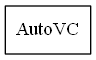

In [71]:
importlib.reload(autovc)
model = autovc.AutoVC()
model.compile(optimizer="Adam")


In [78]:
# model.build(input_shape=[(128,80), (256,)])

In [74]:
mel_post = model(padded_mel_specs, sp_emb, sp_emb)

In [75]:
mel_post.shape

TensorShape([4, 128, 80])

In [76]:
model.summary()

Model: "AutoVC"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  3008256   
_________________________________________________________________
decoder_20 (Decoder)         multiple                  26529360  
_________________________________________________________________
postnet (PostNet)            multiple                  5665680   
_________________________________________________________________
upsampling (UpSampling)      multiple                  0         
Total params: 35,203,296
Trainable params: 35,191,872
Non-trainable params: 11,424
_________________________________________________________________


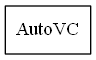

In [77]:
tf.keras.utils.plot_model(model, "model.png")